In [1]:
import pandas as pd
import time
import numpy as np
#from sklearn.cross_validation import train_test_split
import xgboost as xgb
import copy
import matplotlib.pyplot as plt
import scikitplot as skplt
from sklearn import metrics
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"


## Commons function definition




***




In [2]:
def buildROC(target_test,test_preds):
    """ plot roc curve """
    fpr, tpr, threshold = metrics.roc_curve(target_test, test_preds)
    roc_auc = metrics.auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    
    plt.plot([0, 1], [0, 1],'r--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.axis('equal')
    plt.axis([0, 1, 0, 1])
    #plt.gcf().savefig('roc.png')

def zNormPandas(X):
    means = X.mean()
    standarDev = X.std()
    X=X.sub(means)
    return X.div(standarDev)

## data load

load data into pandas


***


In [3]:
path = './data/'

data_train_pd = pd.read_csv(path + "application_train.csv" )#,nrows=10000) #, skiprows=1, nrows=40000
data_test_pd = pd.read_csv(path + "application_test.csv" )#,nrows=10000) #, skiprows=1, nrows=40000

## view data


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,...,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,...,0.008130,0.000595,0.000507,0.000335,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,102790.175348,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,141275.766519,...,0.089798,0.024387,0.022518,0.018299,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-2760.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1213.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,367142.500000,0.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12413.000000,-289.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,456255.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,365243.000000,...,1.000000,1.000000,1.000000,1.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511,307511,307511,307511,307511.000000,3.075110e+05,3.075110e+05,307499.000000,...,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
unique,NaN,NaN,2,3,2,2,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,Cash loans,F,N,Y,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,278232,202448,202924,213312,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,278180.518577,0.080729,NaN,NaN,NaN,NaN,0.417052,1.687979e+05,5.990260e+05,27108.573909,...,0.008130,0.000595,0.000507,0.000335,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,102790.175348,0.272419,NaN,NaN,NaN,NaN,0.722121,2.371231e+05,4.024908e+05,14493.737315,...,0.089798,0.024387,0.022518,0.018299,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,100002.000000,0.000000,NaN,NaN,NaN,NaN,0.000000,2.565000e+04,4.500000e+04,1615.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,NaN,NaN,NaN,NaN,0.000000,1.125000e+05,2.700000e+05,16524.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,NaN,NaN,NaN,NaN,0.000000,1.471500e+05,5.135310e+05,24903.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,367142.500000,0.000000,NaN,NaN,NaN,NaN,1.000000,2.025000e+05,8.086500e+05,34596.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f24a7442978>]],
      dtype=object)

% postive class 8.072881945686495%


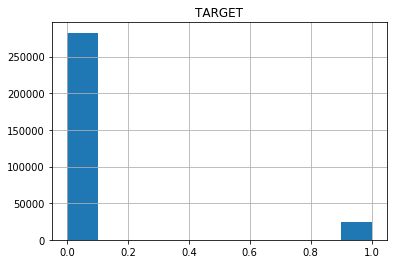

In [4]:
data_train_pd.head()
data_train_pd.describe()
data_train_pd.describe(include='all')
data_train_pd.hist("TARGET")
print("% postive class " + str(np.divide( np.sum(data_train_pd.TARGET), data_train_pd.shape[0])*100) +"%")


## data procesing and split train/val


In [8]:


# only numerical data
data_train_pd = data_train_pd.select_dtypes(include=["int","bool","float"])
data_test_pd = data_test_pd.select_dtypes(include=["int","bool","float"])

y = data_train_pd["TARGET"]
X = data_train_pd.drop(["TARGET","SK_ID_CURR"], axis=1)

amountTrue = sum(y)/len(y)
amountFalse = 1 - amountTrue

def weightFun(X):

    if X==0:
        return 1/amountFalse
    else:
        return 1/amountTrue

weights = list(map(weightFun,X))
weights = np.array(weights)

X = zNormPandas(X)

if False:
    train_X = X
    train_y = y
    test_X = X
    test_y = y
    dtrain = xgb.DMatrix(train_X,label=train_y)
    dtest = xgb.DMatrix(test_X)  
else:
    train_index = np.random.choice(len(X), round(len(X) * 0.7), replace=False)
    val_index = np.array(list(set(range(len(X))) - set(train_index)))

    train_X = X.iloc[train_index]
    #weights_X = weights[train_index]
    train_y = y.iloc[train_index]
    val_X = X.iloc[val_index]
    val_y = y.iloc[val_index]

    dtrain = xgb.DMatrix(train_X,label=train_y)    
    #dtrain = xgb.DMatrix(train_X,label=train_y,weight=weights_X)
    dval = xgb.DMatrix(val_X)    

print(np.divide( np.sum(train_y), train_y.shape[0])*100)
print(np.divide( np.sum(val_y), val_y.shape[0])*100)

8.059166209850504
8.104885477979035


## Train


In [9]:
param = { 'max_depth': 3,
          'learning_rate':0.3,
          'subsample': 0.9, 
          'colsample_bytree': 0.9, 
          'colsample_bylevel':0.9,
          'min_child_weight':10,
          'scale_pos_weight': 1, #0.1
          'alpha':10,
          'objective': 'binary:logistic', 
          'eval_metric': ['auc', 'error'], 
          'random_state': 99,          
          'nthread': 4,
          'n_jobs': 4,
          'silent': False}

param_old = {'max_depth':10,
         'eta':0.5, 
         'silent':0, 
         'objective':'binary:logistic',
         'scale_pos_weight': 0.1 ,
         'nthread': 4,
         'eval_metric': ['auc', 'error']}

num_round = 30 #350

evallist = [ (dtrain, 'train')]
watchlist = [(dtrain, 'train'), (xgb.DMatrix(val_X,label=val_y), 'valid')]

bst = xgb.train(param, dtrain, num_round, watchlist)

[0]	train-auc:0.689263	train-error:0.080592	valid-auc:0.684506	valid-error:0.081049
[1]	train-auc:0.698345	train-error:0.080592	valid-auc:0.692353	valid-error:0.081049
[2]	train-auc:0.706484	train-error:0.080592	valid-auc:0.700601	valid-error:0.081049
[3]	train-auc:0.710062	train-error:0.080592	valid-auc:0.704157	valid-error:0.081049
[4]	train-auc:0.712514	train-error:0.080592	valid-auc:0.706311	valid-error:0.081049
[5]	train-auc:0.71354	train-error:0.080592	valid-auc:0.706987	valid-error:0.081049
[6]	train-auc:0.71714	train-error:0.080592	valid-auc:0.710288	valid-error:0.081049
[7]	train-auc:0.721547	train-error:0.080592	valid-auc:0.714211	valid-error:0.081049
[8]	train-auc:0.726222	train-error:0.080592	valid-auc:0.718509	valid-error:0.081049
[9]	train-auc:0.728376	train-error:0.080592	valid-auc:0.72067	valid-error:0.081049
[10]	train-auc:0.730302	train-error:0.080592	valid-auc:0.722284	valid-error:0.081049
[11]	train-auc:0.734209	train-error:0.080592	valid-auc:0.725916	valid-error:0.

## Evualacion perfomance

67.1739672422577


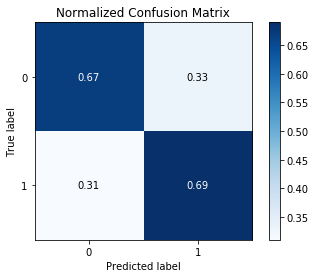

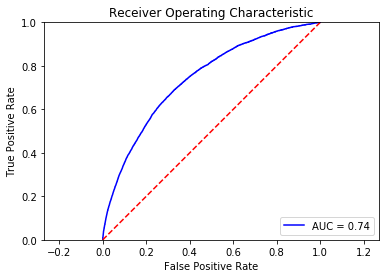

In [35]:
pred = bst.predict(dval, ntree_limit=bst.best_ntree_limit)

fpr, tpr, threshold = metrics.roc_curve(val_y, pred)
maxi = tpr-fpr
best_threshold = threshold[np.argmax(maxi)]

y_pred = pred > best_threshold
y_pred = y_pred.astype(int)
print( sum(val_y==y_pred)/len(y_pred)*100 )
skplt.metrics.plot_confusion_matrix(val_y, y_pred, normalize=True)

plt.show()
buildROC(val_y,pred)

## Submit Data

In [ ]:
submitTest = xgb.DMatrix(data_test_pd.drop(["SK_ID_CURR"], axis=1))
submit = bst.predict(submitTest, ntree_limit=bst.best_ntree_limit)

print(submit.shape)
print(data_test_pd.SK_ID_CURR.shape)
skId=data_test_pd.SK_ID_CURR.values
print(skId)

#dataToSubmit=np.array([ np.array([submit,submit]), skId ])
#SK_ID_CURR,TARGET

data ={'SK_ID_CURR': skId, 
        'TARGET': submit}

df = pd.DataFrame( data)

#df = pd.DataFrame( np.array([submit,submit]),index=skId)
#sub.to_csv('xgb_sub.csv',index=False)
df.to_csv('xgb_sub_3.csv',index=False)